In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

In [3]:
# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)


def generate_longitudinal_dream_data(n_participants=200, n_timepoints=5, country="USA"):
    """
    Generate simulated longitudinal dream survey data matching the exact structure
    of the actual survey (87 columns + 3 new longitudinal tracking columns).

    Parameters:
    n_participants: Number of participants (default=200)
    n_timepoints: Number of monthly assessments (default=5)
    country: 'USA' or 'Argentina'

    Returns:
    DataFrame with longitudinal survey responses
    """

    all_data = []

    # Pre-calculate normalized age probabilities
    age_range = list(range(18, 70))
    age_weights = [3.0 if age < 30 else 1.0 for age in age_range]
    age_probs = np.array(age_weights) / sum(age_weights)

    # Education options and probabilities
    education_options = [
        "Less than high school",
        "High school graduate",
        "Some college",
        "2 year degree",
        "4 year degree",
        "Professional degree",
        "Doctorate",
    ]
    education_probs = [0.02, 0.08, 0.15, 0.10, 0.35, 0.22, 0.08]

    # Gender options
    gender_options = ["Male", "Female", "Non-binary", "Prefer not to say"]
    gender_probs = [0.45, 0.48, 0.05, 0.02]

    # Generate stable person-level characteristics
    person_traits = {}
    for p_id in range(n_participants):
        person_traits[p_id] = {
            "baseline_anxiety": np.random.beta(2, 5) * 21,
            "baseline_depression": np.random.beta(2, 5) * 18,
            "dream_recall_ability": np.random.beta(3, 2) * 10,
            "nightmare_proneness": np.random.beta(2, 4) * 10,
            "age": np.random.choice(age_range, p=age_probs),
            "education": np.random.choice(education_options, p=education_probs),
            "gender": np.random.choice(gender_options, p=gender_probs),
            "student": np.random.choice(["Yes", "No"], p=[0.25, 0.75]),
        }

    # Generate data for each timepoint
    for timepoint in range(n_timepoints):
        month_offset = timepoint

        for p_id in range(n_participants):
            data = {}

            # === NEW LONGITUDINAL TRACKING COLUMNS ===
            data["ParticipantID"] = f"P{p_id:04d}"
            data["Timepoint"] = timepoint + 1
            data["Country"] = country

            # === SURVEY METADATA ===
            start_date = datetime(2024, 3 + month_offset, 1) + timedelta(
                days=random.randint(0, 28),
                hours=random.randint(8, 22),
                minutes=random.randint(0, 59),
            )
            duration_seconds = random.randint(600, 1500)  # 10-25 minutes

            data["StartDate"] = start_date
            data["EndDate"] = start_date + timedelta(seconds=duration_seconds)
            data["Status"] = "IP Address"
            data["IPAddress"] = (
                f"192.168.{random.randint(0,255)}.{random.randint(1,255)}"
            )
            data["Progress"] = 100
            data["Duration (in seconds)"] = duration_seconds
            data["Finished"] = True
            data["RecordedDate"] = data["EndDate"]
            data["ResponseId"] = f"R_{random.randint(10**8, 10**9)}"
            data["RecipientLastName"] = None
            data["RecipientFirstName"] = None
            data["RecipientEmail"] = None
            data["ExternalReference"] = None
            data["LocationLatitude"] = None
            data["LocationLongitude"] = None
            data["DistributionChannel"] = "anonymous"
            data["UserLanguage"] = "EN" if country == "USA" else "ES"
            data["InformedConsent"] = "I consent, begin the study"

            # === DEMOGRAPHICS (stable) ===
            age = person_traits[p_id]["age"]
            if age < 25:
                age_category = "18-24 years old"
            elif age < 35:
                age_category = "25-34 years old"
            elif age < 45:
                age_category = "35-44 years old"
            elif age < 55:
                age_category = "45-54 years old"
            elif age < 65:
                age_category = "55-64 years old"
            else:
                age_category = "65+ years old"

            data["Demo_Age"] = age_category
            data["Demo_Education"] = person_traits[p_id]["education"]
            data["Demo_Student"] = person_traits[p_id]["student"]
            data["Demo_Gender"] = person_traits[p_id]["gender"]

            # === MENTAL HEALTH (temporal variation) ===
            time_trend = np.random.normal(0.3 * timepoint, 0.5)

            anxiety_level = max(
                0,
                min(
                    21,
                    person_traits[p_id]["baseline_anxiety"]
                    + time_trend
                    + np.random.normal(0, 2),
                ),
            )
            depression_level = max(
                0,
                min(
                    27,
                    person_traits[p_id]["baseline_depression"]
                    + 0.6 * (anxiety_level - person_traits[p_id]["baseline_anxiety"])
                    + time_trend
                    + np.random.normal(0, 2),
                ),
            )

            # GAD-7 items
            likert_options = [
                "Not at all",
                "Several days",
                "More than half the days",
                "Nearly every day",
            ]
            for i in range(1, 8):
                item_score = np.clip(anxiety_level / 7 + np.random.normal(0, 0.5), 0, 3)
                data[f"GAD_Bothered_{i}"] = likert_options[int(item_score)]

            difficulty_options = [
                "Not difficult at all",
                "Somewhat difficult",
                "Very difficult",
                "Extremely difficult",
            ]
            data["GAD_DifficultWork_1"] = difficulty_options[
                min(3, int(anxiety_level / 7))
            ]

            # PHQ-9 items
            for i in range(1, 10):
                item_score = np.clip(
                    depression_level / 9 + np.random.normal(0, 0.5), 0, 3
                )
                data[f"PHQ_Bothered_{i}"] = likert_options[int(item_score)]

            data["PHQ_DifficultWork_1"] = difficulty_options[
                min(3, int(depression_level / 9))
            ]

            # Calculated totals (NEW)
            data["GAD_Total"] = round(anxiety_level, 2)
            data["PHQ_Total"] = round(depression_level, 2)

            # === SLEEP VARIABLES ===
            data["Sleep_Alarm"] = np.random.choice(
                ["Naturally", "By alarm", "Both"], p=[0.15, 0.70, 0.15]
            )

            alarm_freq_options = [
                "Never",
                "Less than once a week",
                "Once or twice a week",
                "Three or more times a week",
            ]
            data["Sleep_AlarmFrequency"] = (
                alarm_freq_options[3]
                if data["Sleep_Alarm"] == "By alarm"
                else np.random.choice(alarm_freq_options[:3])
            )

            bedtime_hour = np.random.normal(23, 1.5)
            hour_12 = int(bedtime_hour) % 12
            if hour_12 == 0:
                hour_12 = 12
            data["Sleep_Bedtime"] = (
                f"{hour_12}:{random.choice(['00', '15', '30', '45'])}"
            )

            sleep_time_options = [
                "0-15 minutes",
                "16-30 minutes",
                "31-60 minutes",
                "More than 60 minutes",
            ]
            sleep_onset = min(3, int(anxiety_level / 7 + np.random.uniform(0, 1)))
            data["Sleep_Timetosleep"] = sleep_time_options[sleep_onset]

            med_freq_options = [
                "Not during the past month",
                "Less than once a week",
                "Once or twice a week",
                "Three or more times a week",
            ]
            data["Sleep_Medication"] = np.random.choice(
                med_freq_options, p=[0.6, 0.2, 0.1, 0.1]
            )

            quality_options = ["Very bad", "Fairly bad", "Fairly good", "Very good"]
            sleep_quality = max(
                0, min(3, 3 - anxiety_level / 10 + np.random.normal(0, 0.5))
            )
            data["Sleep_Quality"] = quality_options[int(sleep_quality)]

            data["Sleep_Hours"] = round(
                max(4, min(11, 7 + np.random.normal(0, 1.2))), 1
            )

            disturbed_options = [
                "Not during the past month",
                "Less than once a week",
                "Once or twice a week",
                "Three or more times a week",
            ]
            data["Sleep_Disturbed"] = np.random.choice(
                disturbed_options, p=[0.3, 0.35, 0.25, 0.1]
            )

            data["Sleep_Morning/Eve"] = np.random.choice(
                [
                    "Definitely morning",
                    "More morning than evening",
                    "More evening than morning",
                    "Definitely evening",
                ],
                p=[0.2, 0.3, 0.3, 0.2],
            )

            # === DREAM CHARACTERISTICS ===
            recall_ability = person_traits[p_id]["dream_recall_ability"]

            # Dream memory (text description)
            dream_templates = [
                "I was in a familiar place but everything felt strange and distorted",
                "I was being chased by something threatening but couldn't see what it was",
                "I was trying to complete an important task but kept encountering obstacles",
                "I was flying over landscapes that kept changing",
                "I was with people I know but they looked different or acted strangely",
                "I was in a building with endless rooms and corridors",
                "I was back in school taking an exam I hadn't prepared for",
                "I was searching for something important but couldn't find it",
                "I was trying to speak but no sound would come out",
                "I experienced a vivid emotional reunion with someone from my past",
            ]

            if anxiety_level > 10 or person_traits[p_id]["nightmare_proneness"] > 5:
                negative_elements = [
                    "felt anxious",
                    "threatening atmosphere",
                    "sense of dread",
                    "couldn't escape",
                    "feeling trapped",
                ]
                base_dream = random.choice(dream_templates)
                data["DreamMemory"] = (
                    f"{base_dream}. {random.choice(negative_elements)}."
                )
            else:
                data["DreamMemory"] = random.choice(dream_templates)

            # Dream feelings
            feeling_options = [
                "Very negative",
                "Somewhat negative",
                "Neutral",
                "Somewhat positive",
                "Very positive",
                "NA",
            ]
            feeling_score = max(
                0,
                min(
                    4,
                    2
                    - (anxiety_level + depression_level) / 25
                    + np.random.normal(0, 1),
                ),
            )
            data["Dream_Feelings"] = feeling_options[int(feeling_score)]

            # Dream sharing behaviors
            data["Dream_Talk"] = np.random.choice(["Yes", "No"], p=[0.45, 0.55])

            talk_whom_options = [
                "Partner",
                "Friend",
                "Family",
                "Therapist",
                "Multiple people",
            ]
            data["Dream_TalkWhom"] = (
                random.choice(talk_whom_options)
                if data["Dream_Talk"] == "Yes"
                else None
            )

            data["Dream_Write"] = np.random.choice(["Yes", "No"], p=[0.15, 0.85])

            resemblance_options = ["Not at all", "A little", "Somewhat", "Very much"]
            data["Dream_Content"] = np.random.choice(
                resemblance_options, p=[0.15, 0.35, 0.35, 0.15]
            )

            # Dream frequency
            freq_options = [
                "Never",
                "Less than once a month",
                "About once a month",
                "About once a week",
                "2-3 times a week",
                "4-6 times a week",
                "Every night",
            ]
            dream_freq = min(
                6, max(0, int(recall_ability / 1.5 + np.random.normal(0, 0.5)))
            )
            data["DreamQ_Frequency"] = freq_options[dream_freq]

            # Lucid dreaming
            lucid_freq_options = [
                "Never",
                "Less than once a month",
                "About once a month",
                "About once a week",
                "Several times a week",
            ]
            data["More_LucidDream"] = np.random.choice(
                lucid_freq_options, p=[0.3, 0.35, 0.2, 0.1, 0.05]
            )

            # Dream characteristics
            intensity_scale = [
                "Not at all",
                "Slightly",
                "Moderately",
                "Very",
                "Extremely",
            ]

            vividness = min(
                4, max(0, int(recall_ability / 2.5 + np.random.normal(0, 0.3)))
            )
            data["DreamQ_Vivid_1"] = intensity_scale[vividness]

            data["DreamQ_Bizarre_1"] = intensity_scale[random.randint(0, 4)]

            data["DreamQ_Recurring"] = np.random.choice(
                freq_options, p=[0.25, 0.30, 0.20, 0.15, 0.05, 0.03, 0.02]
            )

            # Dream control
            control_scale = [
                "Not at all in control",
                "Little control",
                "Moderate control",
                "Much control",
                "Complete control",
            ]
            data["DreamQ_FeelControl_1"] = np.random.choice(
                control_scale, p=[0.15, 0.30, 0.35, 0.15, 0.05]
            )
            data["DreamQContentControl_1"] = np.random.choice(
                control_scale, p=[0.20, 0.35, 0.30, 0.10, 0.05]
            )

            controlled_freq_options = [
                "Never",
                "Rarely",
                "Sometimes",
                "Often",
                "Very often",
            ]
            data["DreamQ_ControlFreq_1"] = np.random.choice(
                controlled_freq_options, p=[0.20, 0.30, 0.30, 0.15, 0.05]
            )

            # Dream emotions
            intensity = min(
                4,
                max(
                    0,
                    int(
                        (anxiety_level + depression_level) / 15
                        + np.random.normal(0, 0.5)
                    ),
                ),
            )
            data["More_DreamIntensity_1"] = intensity_scale[intensity]

            emotional_tone_scale = [
                "Very negative",
                "Somewhat negative",
                "Neutral",
                "Somewhat positive",
                "Very positive",
            ]
            tone_score = max(
                0,
                min(
                    4,
                    2
                    - (anxiety_level + depression_level) / 30
                    + np.random.normal(0, 0.8),
                ),
            )
            data["More_EmotionalTone_1"] = emotional_tone_scale[int(tone_score)]

            # Bad dreams and nightmares
            distress_score = min(
                4, max(0, int((anxiety_level + depression_level) / 15))
            )
            data["More_DreamDistress_1"] = intensity_scale[distress_score]

            childhood_freq = ["Never", "Rarely", "Sometimes", "Often", "Very often"]
            data["More_Childhood_1"] = np.random.choice(
                childhood_freq, p=[0.15, 0.30, 0.35, 0.15, 0.05]
            )

            bad_dream_freq = max(
                0,
                min(
                    6,
                    int(
                        (anxiety_level + depression_level) / 12
                        + np.random.uniform(0, 2)
                    ),
                ),
            )
            data["More_BadDreams"] = freq_options[bad_dream_freq]

            reality_options = ["Not at all", "Somewhat", "Very much"]
            data["More_BadDreamReality"] = np.random.choice(
                reality_options, p=[0.3, 0.5, 0.2]
            )

            data["More_BadDreamRecurr"] = np.random.choice(["Yes", "No"], p=[0.3, 0.7])

            # Nightmares
            nightmare_proneness = person_traits[p_id]["nightmare_proneness"]
            nightmare_freq = max(
                0,
                nightmare_proneness / 2
                + anxiety_level / 7
                + depression_level / 9
                + np.random.normal(0, 1),
            )
            nightmare_freq = min(6, int(nightmare_freq))
            data["More_Nightmares"] = freq_options[nightmare_freq]

            nightmare_distress = min(4, int((anxiety_level + nightmare_freq * 2) / 7))
            data["MorNightmaredistress"] = intensity_scale[nightmare_distress]

            data["More_NightmareFreq"] = np.random.choice(
                childhood_freq, p=[0.20, 0.35, 0.30, 0.10, 0.05]
            )

            data["MoreNightmareReality"] = np.random.choice(
                reality_options, p=[0.45, 0.35, 0.2]
            )

            data["More_NightmareRecurr"] = np.random.choice(
                ["Yes", "No"], p=[0.25, 0.75]
            )

            # Dream content themes
            themes = [
                "Falling",
                "Being chased",
                "Flying",
                "Death",
                "Being naked in public",
                "Teeth falling out",
                "Being unprepared",
                "Natural disaster",
                "Being paralyzed by fear",
                "Animals",
            ]
            num_themes = random.randint(0, 5)
            data["More_DreamList"] = (
                ",".join(random.sample(themes, num_themes)) if num_themes > 0 else ""
            )

            # === LIFESTYLE FACTORS ===
            data["More_Coffee"] = np.random.choice(["Yes", "No"], p=[0.7, 0.3])

            if data["More_Coffee"] == "Yes":
                data["More_CoffeeCups"] = random.randint(1, 5)
                coffee_time_options = ["Before noon", "12-3pm", "3-6pm", "After 6pm"]
                data["More_CoffeeTime"] = random.choice(coffee_time_options)
            else:
                data["More_CoffeeCups"] = None
                data["More_CoffeeTime"] = None

            data["More_Stimulants"] = np.random.choice(["Yes", "No"], p=[0.15, 0.85])

            alcohol_freq_options = [
                "Never",
                "Monthly or less",
                "2-4 times a month",
                "Twice a week",
                "3-4 times a week",
                "5+ times a week",
            ]
            data["More_AlcoholFreq"] = np.random.choice(
                alcohol_freq_options, p=[0.2, 0.3, 0.25, 0.15, 0.07, 0.03]
            )

            if data["More_AlcoholFreq"] != "Never":
                alcohol_amount_options = [
                    "1-2 drinks",
                    "3-4 drinks",
                    "5-6 drinks",
                    "7-9 drinks",
                    "10+ drinks",
                ]
                data["More_AlcoholAmount"] = random.choice(alcohol_amount_options)
            else:
                data["More_AlcoholAmount"] = None

            data["More_Cigarettes"] = np.random.choice(
                ["Yes", "No", "Daily"], p=[0.10, 0.85, 0.05]
            )

            living_options = [
                "Alone",
                "With roommates",
                "Living with partner/family",
                "With partner and children",
            ]
            data["More_LivingSituation"] = np.random.choice(
                living_options, p=[0.25, 0.25, 0.35, 0.15]
            )

            data["More_Pets"] = np.random.choice(["Yes", "No"], p=[0.45, 0.55])

            # Prolific IDs
            prolific_id = f"P{random.randint(10**9, 10**10-1)}"
            data["ProlificID"] = prolific_id
            data["PROLIFIC_PID"] = prolific_id

            all_data.append(data)

    df = pd.DataFrame(all_data)

    return df


# Generate datasets
print("=" * 70)
print("LONGITUDINAL DREAM STUDY DATA SIMULATOR")
print("=" * 70)

print("\nGenerating USA sample (200 participants × 5 timepoints)...")
usa_data = generate_longitudinal_dream_data(
    n_participants=200, n_timepoints=5, country="USA"
)

print("Generating Argentina sample (200 participants × 5 timepoints)...")
argentina_data = generate_longitudinal_dream_data(
    n_participants=200, n_timepoints=5, country="Argentina"
)

# Combine datasets
combined_data = pd.concat([usa_data, argentina_data], ignore_index=True)

LONGITUDINAL DREAM STUDY DATA SIMULATOR

Generating USA sample (200 participants × 5 timepoints)...
Generating Argentina sample (200 participants × 5 timepoints)...


In [4]:
print("\n" + "=" * 70)
print("DATASET SUMMARY")
print("=" * 70)
print(f"\nTotal observations: {len(combined_data):,}")
print(
    f"USA: {len(usa_data):,} observations ({len(usa_data)//5} participants × 5 timepoints)"
)
print(
    f"Argentina: {len(argentina_data):,} observations ({len(argentina_data)//5} participants × 5 timepoints)"
)
print(f"\nTotal columns: {len(combined_data.columns)}")
print(f"  - Original survey columns: 87")
print(f"  - New longitudinal tracking columns: 3 (ParticipantID, Timepoint, Country)")

# Save datasets
print("\n" + "=" * 70)
print("SAVING FILES")
print("=" * 70)


# Show temporal trends
print("\n" + "=" * 70)
print("TEMPORAL TRENDS (Mean ± SD)")
print("=" * 70)
temporal = combined_data.groupby(["Country", "Timepoint"])[
    ["GAD_Total", "PHQ_Total"]
].agg(["mean", "std"])
print(temporal.round(2))

# Show correlations
print("\n" + "=" * 70)
print("KEY CORRELATIONS")
print("=" * 70)
print(
    f"GAD-7 & PHQ-9: r = {combined_data['GAD_Total'].corr(combined_data['PHQ_Total']):.3f}"
)

# Sample data preview
print("\n" + "=" * 70)
print("SAMPLE DATA (First 2 participants, first 2 timepoints)")
print("=" * 70)
sample = combined_data[combined_data["ParticipantID"].isin(["P0000", "P0001"])]
sample = sample[sample["Timepoint"].isin([1, 2])]
cols_to_show = [
    "ParticipantID",
    "Timepoint",
    "Country",
    "Demo_Age",
    "GAD_Total",
    "PHQ_Total",
    "More_Nightmares",
    "Sleep_Quality",
    "DreamQ_Frequency",
]
print(sample[cols_to_show].to_string(index=False))

print("\n" + "=" * 70)
print("GENERATION COMPLETE!")
print("=" * 70)


DATASET SUMMARY

Total observations: 2,000
USA: 1,000 observations (200 participants × 5 timepoints)
Argentina: 1,000 observations (200 participants × 5 timepoints)

Total columns: 92
  - Original survey columns: 87
  - New longitudinal tracking columns: 3 (ParticipantID, Timepoint, Country)

SAVING FILES

TEMPORAL TRENDS (Mean ± SD)
                    GAD_Total       PHQ_Total      
                         mean   std      mean   std
Country   Timepoint                                
Argentina 1              6.58  3.95      5.26  3.50
          2              6.66  4.31      5.56  3.66
          3              7.35  4.38      6.40  3.49
          4              7.34  3.95      6.71  3.48
          5              7.60  4.08      7.01  3.74
USA       1              6.10  4.09      5.19  3.18
          2              6.36  4.19      5.66  3.29
          3              6.38  4.03      6.52  3.33
          4              6.87  3.99      6.69  3.65
          5              7.34  3.85    

In [5]:
print(combined_data.columns.tolist())

['ParticipantID', 'Timepoint', 'Country', 'StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress', 'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId', 'RecipientLastName', 'RecipientFirstName', 'RecipientEmail', 'ExternalReference', 'LocationLatitude', 'LocationLongitude', 'DistributionChannel', 'UserLanguage', 'InformedConsent', 'Demo_Age', 'Demo_Education', 'Demo_Student', 'Demo_Gender', 'GAD_Bothered_1', 'GAD_Bothered_2', 'GAD_Bothered_3', 'GAD_Bothered_4', 'GAD_Bothered_5', 'GAD_Bothered_6', 'GAD_Bothered_7', 'GAD_DifficultWork_1', 'PHQ_Bothered_1', 'PHQ_Bothered_2', 'PHQ_Bothered_3', 'PHQ_Bothered_4', 'PHQ_Bothered_5', 'PHQ_Bothered_6', 'PHQ_Bothered_7', 'PHQ_Bothered_8', 'PHQ_Bothered_9', 'PHQ_DifficultWork_1', 'GAD_Total', 'PHQ_Total', 'Sleep_Alarm', 'Sleep_AlarmFrequency', 'Sleep_Bedtime', 'Sleep_Timetosleep', 'Sleep_Medication', 'Sleep_Quality', 'Sleep_Hours', 'Sleep_Disturbed', 'Sleep_Morning/Eve', 'DreamMemory', 'Dream_Feelings', 'Dream_Talk', 'Dream_TalkWho

In [6]:
usa_data.to_csv(
    "/Users/chensi/Desktop/MIDS/Fall 2025/capstone project/simulated_dream_USA_longitudinal.csv",
    index=False,
)
argentina_data.to_csv(
    "/Users/chensi/Desktop/MIDS/Fall 2025/capstone project/simulated_dream_Argentina_longitudinal.csv",
    index=False,
)
combined_data.to_csv(
    "/Users/chensi/Desktop/MIDS/Fall 2025/capstone project/simulated_dream_combined_longitudinal.csv",
    index=False,
)

In [8]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)


def generate_single_timepoint_data(
    n_participants=200, timepoint=1, country="USA", person_traits=None
):
    """
    Generate data for a single timepoint only (simulating one month's data collection).

    Parameters:
    n_participants: Number of participants
    timepoint: Which timepoint (1-5)
    country: 'USA' or 'Argentina'
    person_traits: Dictionary of stable person characteristics (to maintain consistency across timepoints)

    Returns:
    DataFrame with single timepoint survey responses
    """

    all_data = []
    month_offset = timepoint - 1

    # If no person_traits provided, generate them (for first timepoint)
    if person_traits is None:
        person_traits = generate_person_traits(n_participants)

    for p_id in range(n_participants):
        data = {}

        # === NEW LONGITUDINAL TRACKING COLUMNS ===
        data["ParticipantID"] = f"P{p_id:04d}"
        data["Timepoint"] = timepoint
        data["Country"] = country

        # === SURVEY METADATA ===
        start_date = datetime(2024, 3 + month_offset, 1) + timedelta(
            days=random.randint(0, 28),
            hours=random.randint(8, 22),
            minutes=random.randint(0, 59),
        )
        duration_seconds = random.randint(600, 1500)

        data["StartDate"] = start_date
        data["EndDate"] = start_date + timedelta(seconds=duration_seconds)
        data["Status"] = "IP Address"
        data["IPAddress"] = f"192.168.{random.randint(0,255)}.{random.randint(1,255)}"
        data["Progress"] = 100
        data["Duration (in seconds)"] = duration_seconds
        data["Finished"] = True
        data["RecordedDate"] = data["EndDate"]
        data["ResponseId"] = f"R_{random.randint(10**8, 10**9)}"
        data["RecipientLastName"] = None
        data["RecipientFirstName"] = None
        data["RecipientEmail"] = None
        data["ExternalReference"] = None
        data["LocationLatitude"] = None
        data["LocationLongitude"] = None
        data["DistributionChannel"] = "anonymous"
        data["UserLanguage"] = "EN" if country == "USA" else "ES"
        data["InformedConsent"] = "I consent, begin the study"

        # === DEMOGRAPHICS (stable) ===
        age = person_traits[p_id]["age"]
        if age < 25:
            age_category = "18-24 years old"
        elif age < 35:
            age_category = "25-34 years old"
        elif age < 45:
            age_category = "35-44 years old"
        elif age < 55:
            age_category = "45-54 years old"
        elif age < 65:
            age_category = "55-64 years old"
        else:
            age_category = "65+ years old"

        data["Demo_Age"] = age_category
        data["Demo_Education"] = person_traits[p_id]["education"]
        data["Demo_Student"] = person_traits[p_id]["student"]
        data["Demo_Gender"] = person_traits[p_id]["gender"]

        # === MENTAL HEALTH (temporal variation) ===
        time_trend = np.random.normal(0.3 * month_offset, 0.5)

        anxiety_level = max(
            0,
            min(
                21,
                person_traits[p_id]["baseline_anxiety"]
                + time_trend
                + np.random.normal(0, 2),
            ),
        )
        depression_level = max(
            0,
            min(
                27,
                person_traits[p_id]["baseline_depression"]
                + 0.6 * (anxiety_level - person_traits[p_id]["baseline_anxiety"])
                + time_trend
                + np.random.normal(0, 2),
            ),
        )

        # GAD-7 items
        likert_options = [
            "Not at all",
            "Several days",
            "More than half the days",
            "Nearly every day",
        ]
        for i in range(1, 8):
            item_score = np.clip(anxiety_level / 7 + np.random.normal(0, 0.5), 0, 3)
            data[f"GAD_Bothered_{i}"] = likert_options[int(item_score)]

        difficulty_options = [
            "Not difficult at all",
            "Somewhat difficult",
            "Very difficult",
            "Extremely difficult",
        ]
        data["GAD_DifficultWork_1"] = difficulty_options[min(3, int(anxiety_level / 7))]

        # PHQ-9 items
        for i in range(1, 10):
            item_score = np.clip(depression_level / 9 + np.random.normal(0, 0.5), 0, 3)
            data[f"PHQ_Bothered_{i}"] = likert_options[int(item_score)]

        data["PHQ_DifficultWork_1"] = difficulty_options[
            min(3, int(depression_level / 9))
        ]

        # Calculated totals
        data["GAD_Total"] = round(anxiety_level, 2)
        data["PHQ_Total"] = round(depression_level, 2)

        # === SLEEP VARIABLES ===
        data["Sleep_Alarm"] = np.random.choice(
            ["Naturally", "By alarm", "Both"], p=[0.15, 0.70, 0.15]
        )

        alarm_freq_options = [
            "Never",
            "Less than once a week",
            "Once or twice a week",
            "Three or more times a week",
        ]
        data["Sleep_AlarmFrequency"] = (
            alarm_freq_options[3]
            if data["Sleep_Alarm"] == "By alarm"
            else np.random.choice(alarm_freq_options[:3])
        )

        bedtime_hour = np.random.normal(23, 1.5)
        hour_12 = int(bedtime_hour) % 12
        if hour_12 == 0:
            hour_12 = 12
        data["Sleep_Bedtime"] = f"{hour_12}:{random.choice(['00', '15', '30', '45'])}"

        sleep_time_options = [
            "0-15 minutes",
            "16-30 minutes",
            "31-60 minutes",
            "More than 60 minutes",
        ]
        sleep_onset = min(3, int(anxiety_level / 7 + np.random.uniform(0, 1)))
        data["Sleep_Timetosleep"] = sleep_time_options[sleep_onset]

        med_freq_options = [
            "Not during the past month",
            "Less than once a week",
            "Once or twice a week",
            "Three or more times a week",
        ]
        data["Sleep_Medication"] = np.random.choice(
            med_freq_options, p=[0.6, 0.2, 0.1, 0.1]
        )

        quality_options = ["Very bad", "Fairly bad", "Fairly good", "Very good"]
        sleep_quality = max(
            0, min(3, 3 - anxiety_level / 10 + np.random.normal(0, 0.5))
        )
        data["Sleep_Quality"] = quality_options[int(sleep_quality)]

        data["Sleep_Hours"] = round(max(4, min(11, 7 + np.random.normal(0, 1.2))), 1)

        disturbed_options = [
            "Not during the past month",
            "Less than once a week",
            "Once or twice a week",
            "Three or more times a week",
        ]
        data["Sleep_Disturbed"] = np.random.choice(
            disturbed_options, p=[0.3, 0.35, 0.25, 0.1]
        )

        data["Sleep_Morning/Eve"] = np.random.choice(
            [
                "Definitely morning",
                "More morning than evening",
                "More evening than morning",
                "Definitely evening",
            ],
            p=[0.2, 0.3, 0.3, 0.2],
        )

        # === DREAM CHARACTERISTICS ===
        recall_ability = person_traits[p_id]["dream_recall_ability"]

        dream_templates = [
            "I was in a familiar place but everything felt strange and distorted",
            "I was being chased by something threatening but couldn't see what it was",
            "I was trying to complete an important task but kept encountering obstacles",
            "I was flying over landscapes that kept changing",
            "I was with people I know but they looked different or acted strangely",
            "I was in a building with endless rooms and corridors",
            "I was back in school taking an exam I hadn't prepared for",
            "I was searching for something important but couldn't find it",
            "I was trying to speak but no sound would come out",
            "I experienced a vivid emotional reunion with someone from my past",
        ]

        if anxiety_level > 10 or person_traits[p_id]["nightmare_proneness"] > 5:
            negative_elements = [
                "felt anxious",
                "threatening atmosphere",
                "sense of dread",
                "couldn't escape",
                "feeling trapped",
            ]
            base_dream = random.choice(dream_templates)
            data["DreamMemory"] = f"{base_dream}. {random.choice(negative_elements)}."
        else:
            data["DreamMemory"] = random.choice(dream_templates)

        feeling_options = [
            "Very negative",
            "Somewhat negative",
            "Neutral",
            "Somewhat positive",
            "Very positive",
            "NA",
        ]
        feeling_score = max(
            0,
            min(
                4, 2 - (anxiety_level + depression_level) / 25 + np.random.normal(0, 1)
            ),
        )
        data["Dream_Feelings"] = feeling_options[int(feeling_score)]

        data["Dream_Talk"] = np.random.choice(["Yes", "No"], p=[0.45, 0.55])

        talk_whom_options = [
            "Partner",
            "Friend",
            "Family",
            "Therapist",
            "Multiple people",
        ]
        data["Dream_TalkWhom"] = (
            random.choice(talk_whom_options) if data["Dream_Talk"] == "Yes" else None
        )

        data["Dream_Write"] = np.random.choice(["Yes", "No"], p=[0.15, 0.85])

        resemblance_options = ["Not at all", "A little", "Somewhat", "Very much"]
        data["Dream_Content"] = np.random.choice(
            resemblance_options, p=[0.15, 0.35, 0.35, 0.15]
        )

        freq_options = [
            "Never",
            "Less than once a month",
            "About once a month",
            "About once a week",
            "2-3 times a week",
            "4-6 times a week",
            "Every night",
        ]
        dream_freq = min(
            6, max(0, int(recall_ability / 1.5 + np.random.normal(0, 0.5)))
        )
        data["DreamQ_Frequency"] = freq_options[dream_freq]

        lucid_freq_options = [
            "Never",
            "Less than once a month",
            "About once a month",
            "About once a week",
            "Several times a week",
        ]
        data["More_LucidDream"] = np.random.choice(
            lucid_freq_options, p=[0.3, 0.35, 0.2, 0.1, 0.05]
        )

        intensity_scale = ["Not at all", "Slightly", "Moderately", "Very", "Extremely"]

        vividness = min(4, max(0, int(recall_ability / 2.5 + np.random.normal(0, 0.3))))
        data["DreamQ_Vivid_1"] = intensity_scale[vividness]

        data["DreamQ_Bizarre_1"] = intensity_scale[random.randint(0, 4)]

        data["DreamQ_Recurring"] = np.random.choice(
            freq_options, p=[0.25, 0.30, 0.20, 0.15, 0.05, 0.03, 0.02]
        )

        control_scale = [
            "Not at all in control",
            "Little control",
            "Moderate control",
            "Much control",
            "Complete control",
        ]
        data["DreamQ_FeelControl_1"] = np.random.choice(
            control_scale, p=[0.15, 0.30, 0.35, 0.15, 0.05]
        )
        data["DreamQContentControl_1"] = np.random.choice(
            control_scale, p=[0.20, 0.35, 0.30, 0.10, 0.05]
        )

        controlled_freq_options = [
            "Never",
            "Rarely",
            "Sometimes",
            "Often",
            "Very often",
        ]
        data["DreamQ_ControlFreq_1"] = np.random.choice(
            controlled_freq_options, p=[0.20, 0.30, 0.30, 0.15, 0.05]
        )

        intensity = min(
            4,
            max(
                0,
                int((anxiety_level + depression_level) / 15 + np.random.normal(0, 0.5)),
            ),
        )
        data["More_DreamIntensity_1"] = intensity_scale[intensity]

        emotional_tone_scale = [
            "Very negative",
            "Somewhat negative",
            "Neutral",
            "Somewhat positive",
            "Very positive",
        ]
        tone_score = max(
            0,
            min(
                4,
                2 - (anxiety_level + depression_level) / 30 + np.random.normal(0, 0.8),
            ),
        )
        data["More_EmotionalTone_1"] = emotional_tone_scale[int(tone_score)]

        distress_score = min(4, max(0, int((anxiety_level + depression_level) / 15)))
        data["More_DreamDistress_1"] = intensity_scale[distress_score]

        childhood_freq = ["Never", "Rarely", "Sometimes", "Often", "Very often"]
        data["More_Childhood_1"] = np.random.choice(
            childhood_freq, p=[0.15, 0.30, 0.35, 0.15, 0.05]
        )

        bad_dream_freq = max(
            0,
            min(
                6,
                int((anxiety_level + depression_level) / 12 + np.random.uniform(0, 2)),
            ),
        )
        data["More_BadDreams"] = freq_options[bad_dream_freq]

        reality_options = ["Not at all", "Somewhat", "Very much"]
        data["More_BadDreamReality"] = np.random.choice(
            reality_options, p=[0.3, 0.5, 0.2]
        )

        data["More_BadDreamRecurr"] = np.random.choice(["Yes", "No"], p=[0.3, 0.7])

        nightmare_proneness = person_traits[p_id]["nightmare_proneness"]
        nightmare_freq = max(
            0,
            nightmare_proneness / 2
            + anxiety_level / 7
            + depression_level / 9
            + np.random.normal(0, 1),
        )
        nightmare_freq = min(6, int(nightmare_freq))
        data["More_Nightmares"] = freq_options[nightmare_freq]

        nightmare_distress = min(4, int((anxiety_level + nightmare_freq * 2) / 7))
        data["MorNightmaredistress"] = intensity_scale[nightmare_distress]

        data["More_NightmareFreq"] = np.random.choice(
            childhood_freq, p=[0.20, 0.35, 0.30, 0.10, 0.05]
        )

        data["MoreNightmareReality"] = np.random.choice(
            reality_options, p=[0.45, 0.35, 0.2]
        )

        data["More_NightmareRecurr"] = np.random.choice(["Yes", "No"], p=[0.25, 0.75])

        themes = [
            "Falling",
            "Being chased",
            "Flying",
            "Death",
            "Being naked in public",
            "Teeth falling out",
            "Being unprepared",
            "Natural disaster",
            "Being paralyzed by fear",
            "Animals",
        ]
        num_themes = random.randint(0, 5)
        data["More_DreamList"] = (
            ",".join(random.sample(themes, num_themes)) if num_themes > 0 else ""
        )

        # === LIFESTYLE FACTORS ===
        data["More_Coffee"] = np.random.choice(["Yes", "No"], p=[0.7, 0.3])

        if data["More_Coffee"] == "Yes":
            data["More_CoffeeCups"] = random.randint(1, 5)
            coffee_time_options = ["Before noon", "12-3pm", "3-6pm", "After 6pm"]
            data["More_CoffeeTime"] = random.choice(coffee_time_options)
        else:
            data["More_CoffeeCups"] = None
            data["More_CoffeeTime"] = None

        data["More_Stimulants"] = np.random.choice(["Yes", "No"], p=[0.15, 0.85])

        alcohol_freq_options = [
            "Never",
            "Monthly or less",
            "2-4 times a month",
            "Twice a week",
            "3-4 times a week",
            "5+ times a week",
        ]
        data["More_AlcoholFreq"] = np.random.choice(
            alcohol_freq_options, p=[0.2, 0.3, 0.25, 0.15, 0.07, 0.03]
        )

        if data["More_AlcoholFreq"] != "Never":
            alcohol_amount_options = [
                "1-2 drinks",
                "3-4 drinks",
                "5-6 drinks",
                "7-9 drinks",
                "10+ drinks",
            ]
            data["More_AlcoholAmount"] = random.choice(alcohol_amount_options)
        else:
            data["More_AlcoholAmount"] = None

        data["More_Cigarettes"] = np.random.choice(
            ["Yes", "No", "Daily"], p=[0.10, 0.85, 0.05]
        )

        living_options = [
            "Alone",
            "With roommates",
            "Living with partner/family",
            "With partner and children",
        ]
        data["More_LivingSituation"] = np.random.choice(
            living_options, p=[0.25, 0.25, 0.35, 0.15]
        )

        data["More_Pets"] = np.random.choice(["Yes", "No"], p=[0.45, 0.55])

        prolific_id = f"P{random.randint(10**9, 10**10-1)}"
        data["ProlificID"] = prolific_id
        data["PROLIFIC_PID"] = prolific_id

        all_data.append(data)

    return pd.DataFrame(all_data), person_traits


def generate_person_traits(n_participants):
    """Generate stable person-level characteristics"""
    age_range = list(range(18, 70))
    age_weights = [3.0 if age < 30 else 1.0 for age in age_range]
    age_probs = np.array(age_weights) / sum(age_weights)

    education_options = [
        "Less than high school",
        "High school graduate",
        "Some college",
        "2 year degree",
        "4 year degree",
        "Professional degree",
        "Doctorate",
    ]
    education_probs = [0.02, 0.08, 0.15, 0.10, 0.35, 0.22, 0.08]

    gender_options = ["Male", "Female", "Non-binary", "Prefer not to say"]
    gender_probs = [0.45, 0.48, 0.05, 0.02]

    person_traits = {}
    for p_id in range(n_participants):
        person_traits[p_id] = {
            "baseline_anxiety": np.random.beta(2, 5) * 21,
            "baseline_depression": np.random.beta(2, 5) * 18,
            "dream_recall_ability": np.random.beta(3, 2) * 10,
            "nightmare_proneness": np.random.beta(2, 4) * 10,
            "age": np.random.choice(age_range, p=age_probs),
            "education": np.random.choice(education_options, p=education_probs),
            "gender": np.random.choice(gender_options, p=gender_probs),
            "student": np.random.choice(["Yes", "No"], p=[0.25, 0.75]),
        }
    return person_traits


# ============================================================================
# MAIN EXECUTION: Generate separate files for each timepoint
# ============================================================================

print("=" * 70)
print("LONGITUDINAL DREAM STUDY - SEPARATE TIMEPOINT DATA GENERATOR")
print("=" * 70)

# Generate person traits once for each country (to maintain consistency)
print("\nGenerating stable participant characteristics...")
usa_traits = generate_person_traits(200)
argentina_traits = generate_person_traits(200)

# Generate USA datasets (5 separate files)
print("\n" + "=" * 70)
print("GENERATING USA DATASETS")
print("=" * 70)

for t in range(1, 6):
    print(f"\nTimepoint {t} (Month {2024 + (t-1+3)//12}-{(t-1+3)%12 + 1})...")
    usa_df, _ = generate_single_timepoint_data(
        n_participants=200, timepoint=t, country="USA", person_traits=usa_traits
    )
    filename = f"usa_dream_study_month{t}.csv"
    usa_df.to_csv(filename, index=False)
    print(f"  ✓ Saved: {filename} ({len(usa_df)} participants)")

# Generate Argentina datasets (5 separate files)
print("\n" + "=" * 70)
print("GENERATING ARGENTINA DATASETS")
print("=" * 70)

for t in range(1, 6):
    print(f"\nTimepoint {t} (Month {2024 + (t-1+3)//12}-{(t-1+3)%12 + 1})...")
    arg_df, _ = generate_single_timepoint_data(
        n_participants=200,
        timepoint=t,
        country="Argentina",
        person_traits=argentina_traits,
    )
    filename = f"argentina_dream_study_month{t}.csv"
    arg_df.to_csv(filename, index=False)
    print(f"  ✓ Saved: {filename} ({len(arg_df)} participants)")

print("\n" + "=" * 70)
print("DATA GENERATION COMPLETE!")
print("=" * 70)
print(f"\n✓ Generated 10 CSV files total:")
print(f"  • 5 USA monthly files (usa_dream_study_month1.csv to month5.csv)")
print(f"  • 5 Argentina monthly files (argentina_dream_study_month1.csv to month5.csv)")
print(f"\nEach file contains 200 participants for that specific timepoint.")
print(f"ParticipantID remains consistent across timepoints for tracking.")
print("=" * 70)

LONGITUDINAL DREAM STUDY - SEPARATE TIMEPOINT DATA GENERATOR

Generating stable participant characteristics...

GENERATING USA DATASETS

Timepoint 1 (Month 2024-4)...
  ✓ Saved: usa_dream_study_month1.csv (200 participants)

Timepoint 2 (Month 2024-5)...
  ✓ Saved: usa_dream_study_month2.csv (200 participants)

Timepoint 3 (Month 2024-6)...
  ✓ Saved: usa_dream_study_month3.csv (200 participants)

Timepoint 4 (Month 2024-7)...
  ✓ Saved: usa_dream_study_month4.csv (200 participants)

Timepoint 5 (Month 2024-8)...
  ✓ Saved: usa_dream_study_month5.csv (200 participants)

GENERATING ARGENTINA DATASETS

Timepoint 1 (Month 2024-4)...
  ✓ Saved: argentina_dream_study_month1.csv (200 participants)

Timepoint 2 (Month 2024-5)...
  ✓ Saved: argentina_dream_study_month2.csv (200 participants)

Timepoint 3 (Month 2024-6)...
  ✓ Saved: argentina_dream_study_month3.csv (200 participants)

Timepoint 4 (Month 2024-7)...
  ✓ Saved: argentina_dream_study_month4.csv (200 participants)

Timepoint 5 (Mon

### add some chaos into the dataset

In [19]:
# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)


def generate_single_timepoint_data(
    n_participants=200,
    timepoint=1,
    country="USA",
    person_traits=None,
    active_participants=None,
):
    """
    Generate data for a single timepoint only (simulating one month's data collection).
    Returns: df, person_traits, active_participants
    """
    all_data = []
    month_offset = timepoint - 1

    # If no person_traits provided, generate them (for first timepoint)
    if person_traits is None:
        person_traits = generate_person_traits(n_participants)
        active_participants = list(range(n_participants))

    # Only generate data for active participants
    if active_participants is None:
        active_participants = list(range(n_participants))

    current_participants = active_participants.copy()
    current_participants = active_participants.copy()

    for p_id in current_participants:
        data = {}

        # === NEW LONGITUDINAL TRACKING COLUMNS ===
        data["ParticipantID"] = f"P{p_id:04d}"
        data["Timepoint"] = timepoint
        data["Country"] = country

        # === SURVEY METADATA ===
        start_date = datetime(2024, 3 + month_offset, 1) + timedelta(
            days=random.randint(0, 28),
            hours=random.randint(8, 22),
            minutes=random.randint(0, 59),
        )
        duration_seconds = random.randint(600, 1500)

        data["StartDate"] = start_date
        data["EndDate"] = start_date + timedelta(seconds=duration_seconds)
        data["Status"] = "IP Address"
        data["IPAddress"] = f"192.168.{random.randint(0,255)}.{random.randint(1,255)}"
        data["Progress"] = 100
        data["Duration (in seconds)"] = duration_seconds
        data["Finished"] = True
        data["RecordedDate"] = data["EndDate"]
        data["ResponseId"] = f"R_{random.randint(10**8, 10**9)}"
        data["RecipientLastName"] = None
        data["RecipientFirstName"] = None
        data["RecipientEmail"] = None
        data["ExternalReference"] = None
        data["LocationLatitude"] = None
        data["LocationLongitude"] = None
        data["DistributionChannel"] = "anonymous"
        data["UserLanguage"] = "EN" if country == "USA" else "ES"
        data["InformedConsent"] = "I consent, begin the study"

        # === DEMOGRAPHICS (stable) ===
        age = person_traits[p_id]["age"]
        if age < 25:
            age_category = "18-24 years old"
        elif age < 35:
            age_category = "25-34 years old"
        elif age < 45:
            age_category = "35-44 years old"
        elif age < 55:
            age_category = "45-54 years old"
        elif age < 65:
            age_category = "55-64 years old"
        else:
            age_category = "65+ years old"

        data["Demo_Age"] = age_category
        data["Demo_Education"] = person_traits[p_id]["education"]
        data["Demo_Student"] = person_traits[p_id]["student"]
        data["Demo_Gender"] = person_traits[p_id]["gender"]

        # === MENTAL HEALTH (temporal variation) ===
        time_trend = np.random.normal(0.3 * month_offset, 0.5)

        anxiety_level = max(
            0,
            min(
                21,
                person_traits[p_id]["baseline_anxiety"]
                + time_trend
                + np.random.normal(0, 2),
            ),
        )
        depression_level = max(
            0,
            min(
                27,
                person_traits[p_id]["baseline_depression"]
                + 0.6 * (anxiety_level - person_traits[p_id]["baseline_anxiety"])
                + time_trend
                + np.random.normal(0, 2),
            ),
        )

        # GAD-7 items
        likert_options = [
            "Not at all",
            "Several days",
            "More than half the days",
            "Nearly every day",
        ]
        for i in range(1, 8):
            item_score = np.clip(anxiety_level / 7 + np.random.normal(0, 0.5), 0, 3)
            data[f"GAD_Bothered_{i}"] = likert_options[int(item_score)]

        difficulty_options = [
            "Not difficult at all",
            "Somewhat difficult",
            "Very difficult",
            "Extremely difficult",
        ]
        data["GAD_DifficultWork_1"] = difficulty_options[min(3, int(anxiety_level / 7))]

        # PHQ-9 items
        for i in range(1, 10):
            item_score = np.clip(depression_level / 9 + np.random.normal(0, 0.5), 0, 3)
            data[f"PHQ_Bothered_{i}"] = likert_options[int(item_score)]

        data["PHQ_DifficultWork_1"] = difficulty_options[
            min(3, int(depression_level / 9))
        ]

        # Calculated totals
        data["GAD_Total"] = round(anxiety_level, 2)
        data["PHQ_Total"] = round(depression_level, 2)

        # === SLEEP VARIABLES ===
        data["Sleep_Alarm"] = np.random.choice(
            ["Naturally", "By alarm", "Both"], p=[0.15, 0.70, 0.15]
        )

        alarm_freq_options = [
            "Never",
            "Less than once a week",
            "Once or twice a week",
            "Three or more times a week",
        ]
        data["Sleep_AlarmFrequency"] = (
            alarm_freq_options[3]
            if data["Sleep_Alarm"] == "By alarm"
            else np.random.choice(alarm_freq_options[:3])
        )

        bedtime_hour = np.random.normal(23, 1.5)
        hour_12 = int(bedtime_hour) % 12
        if hour_12 == 0:
            hour_12 = 12
        data["Sleep_Bedtime"] = f"{hour_12}:{random.choice(['00', '15', '30', '45'])}"

        sleep_time_options = [
            "0-15 minutes",
            "16-30 minutes",
            "31-60 minutes",
            "More than 60 minutes",
        ]
        sleep_onset = min(3, int(anxiety_level / 7 + np.random.uniform(0, 1)))
        data["Sleep_Timetosleep"] = sleep_time_options[sleep_onset]

        med_freq_options = [
            "Not during the past month",
            "Less than once a week",
            "Once or twice a week",
            "Three or more times a week",
        ]
        data["Sleep_Medication"] = np.random.choice(
            med_freq_options, p=[0.6, 0.2, 0.1, 0.1]
        )

        quality_options = ["Very bad", "Fairly bad", "Fairly good", "Very good"]
        sleep_quality = max(
            0, min(3, 3 - anxiety_level / 10 + np.random.normal(0, 0.5))
        )
        data["Sleep_Quality"] = quality_options[int(sleep_quality)]

        data["Sleep_Hours"] = round(max(4, min(11, 7 + np.random.normal(0, 1.2))), 1)

        disturbed_options = [
            "Not during the past month",
            "Less than once a week",
            "Once or twice a week",
            "Three or more times a week",
        ]
        data["Sleep_Disturbed"] = np.random.choice(
            disturbed_options, p=[0.3, 0.35, 0.25, 0.1]
        )

        data["Sleep_Morning/Eve"] = np.random.choice(
            [
                "Definitely morning",
                "More morning than evening",
                "More evening than morning",
                "Definitely evening",
            ],
            p=[0.2, 0.3, 0.3, 0.2],
        )

        # === DREAM CHARACTERISTICS ===
        recall_ability = person_traits[p_id]["dream_recall_ability"]

        dream_templates = [
            "I was in a familiar place but everything felt strange and distorted",
            "I was being chased by something threatening but couldn't see what it was",
            "I was trying to complete an important task but kept encountering obstacles",
            "I was flying over landscapes that kept changing",
            "I was with people I know but they looked different or acted strangely",
            "I was in a building with endless rooms and corridors",
            "I was back in school taking an exam I hadn't prepared for",
            "I was searching for something important but couldn't find it",
            "I was trying to speak but no sound would come out",
            "I experienced a vivid emotional reunion with someone from my past",
        ]

        if anxiety_level > 10 or person_traits[p_id]["nightmare_proneness"] > 5:
            negative_elements = [
                "felt anxious",
                "threatening atmosphere",
                "sense of dread",
                "couldn't escape",
                "feeling trapped",
            ]
            base_dream = random.choice(dream_templates)
            data["DreamMemory"] = f"{base_dream}. {random.choice(negative_elements)}."
        else:
            data["DreamMemory"] = random.choice(dream_templates)

        feeling_options = [
            "Very negative",
            "Somewhat negative",
            "Neutral",
            "Somewhat positive",
            "Very positive",
            "NA",
        ]
        feeling_score = max(
            0,
            min(
                4, 2 - (anxiety_level + depression_level) / 25 + np.random.normal(0, 1)
            ),
        )
        data["Dream_Feelings"] = feeling_options[int(feeling_score)]

        data["Dream_Talk"] = np.random.choice(["Yes", "No"], p=[0.45, 0.55])

        talk_whom_options = [
            "Partner",
            "Friend",
            "Family",
            "Therapist",
            "Multiple people",
        ]
        data["Dream_TalkWhom"] = (
            random.choice(talk_whom_options) if data["Dream_Talk"] == "Yes" else None
        )

        data["Dream_Write"] = np.random.choice(["Yes", "No"], p=[0.15, 0.85])

        resemblance_options = ["Not at all", "A little", "Somewhat", "Very much"]
        data["Dream_Content"] = np.random.choice(
            resemblance_options, p=[0.15, 0.35, 0.35, 0.15]
        )

        freq_options = [
            "Never",
            "Less than once a month",
            "About once a month",
            "About once a week",
            "2-3 times a week",
            "4-6 times a week",
            "Every night",
        ]
        dream_freq = min(
            6, max(0, int(recall_ability / 1.5 + np.random.normal(0, 0.5)))
        )
        data["DreamQ_Frequency"] = freq_options[dream_freq]

        lucid_freq_options = [
            "Never",
            "Less than once a month",
            "About once a month",
            "About once a week",
            "Several times a week",
        ]
        data["More_LucidDream"] = np.random.choice(
            lucid_freq_options, p=[0.3, 0.35, 0.2, 0.1, 0.05]
        )

        intensity_scale = ["Not at all", "Slightly", "Moderately", "Very", "Extremely"]

        vividness = min(4, max(0, int(recall_ability / 2.5 + np.random.normal(0, 0.3))))
        data["DreamQ_Vivid_1"] = intensity_scale[vividness]

        data["DreamQ_Bizarre_1"] = intensity_scale[random.randint(0, 4)]

        data["DreamQ_Recurring"] = np.random.choice(
            freq_options, p=[0.25, 0.30, 0.20, 0.15, 0.05, 0.03, 0.02]
        )

        control_scale = [
            "Not at all in control",
            "Little control",
            "Moderate control",
            "Much control",
            "Complete control",
        ]
        data["DreamQ_FeelControl_1"] = np.random.choice(
            control_scale, p=[0.15, 0.30, 0.35, 0.15, 0.05]
        )
        data["DreamQContentControl_1"] = np.random.choice(
            control_scale, p=[0.20, 0.35, 0.30, 0.10, 0.05]
        )

        controlled_freq_options = [
            "Never",
            "Rarely",
            "Sometimes",
            "Often",
            "Very often",
        ]
        data["DreamQ_ControlFreq_1"] = np.random.choice(
            controlled_freq_options, p=[0.20, 0.30, 0.30, 0.15, 0.05]
        )

        intensity = min(
            4,
            max(
                0,
                int((anxiety_level + depression_level) / 15 + np.random.normal(0, 0.5)),
            ),
        )
        data["More_DreamIntensity_1"] = intensity_scale[intensity]

        emotional_tone_scale = [
            "Very negative",
            "Somewhat negative",
            "Neutral",
            "Somewhat positive",
            "Very positive",
        ]
        tone_score = max(
            0,
            min(
                4,
                2 - (anxiety_level + depression_level) / 30 + np.random.normal(0, 0.8),
            ),
        )
        data["More_EmotionalTone_1"] = emotional_tone_scale[int(tone_score)]

        distress_score = min(4, max(0, int((anxiety_level + depression_level) / 15)))
        data["More_DreamDistress_1"] = intensity_scale[distress_score]

        childhood_freq = ["Never", "Rarely", "Sometimes", "Often", "Very often"]
        data["More_Childhood_1"] = np.random.choice(
            childhood_freq, p=[0.15, 0.30, 0.35, 0.15, 0.05]
        )

        bad_dream_freq = max(
            0,
            min(
                6,
                int((anxiety_level + depression_level) / 12 + np.random.uniform(0, 2)),
            ),
        )
        data["More_BadDreams"] = freq_options[bad_dream_freq]

        reality_options = ["Not at all", "Somewhat", "Very much"]
        data["More_BadDreamReality"] = np.random.choice(
            reality_options, p=[0.3, 0.5, 0.2]
        )

        data["More_BadDreamRecurr"] = np.random.choice(["Yes", "No"], p=[0.3, 0.7])

        nightmare_proneness = person_traits[p_id]["nightmare_proneness"]
        nightmare_freq = max(
            0,
            nightmare_proneness / 2
            + anxiety_level / 7
            + depression_level / 9
            + np.random.normal(0, 1),
        )
        nightmare_freq = min(6, int(nightmare_freq))
        data["More_Nightmares"] = freq_options[nightmare_freq]

        nightmare_distress = min(4, int((anxiety_level + nightmare_freq * 2) / 7))
        data["MorNightmaredistress"] = intensity_scale[nightmare_distress]

        data["More_NightmareFreq"] = np.random.choice(
            childhood_freq, p=[0.20, 0.35, 0.30, 0.10, 0.05]
        )

        data["MoreNightmareReality"] = np.random.choice(
            reality_options, p=[0.45, 0.35, 0.2]
        )

        data["More_NightmareRecurr"] = np.random.choice(["Yes", "No"], p=[0.25, 0.75])

        themes = [
            "Falling",
            "Being chased",
            "Flying",
            "Death",
            "Being naked in public",
            "Teeth falling out",
            "Being unprepared",
            "Natural disaster",
            "Being paralyzed by fear",
            "Animals",
        ]
        num_themes = random.randint(0, 5)
        data["More_DreamList"] = (
            ",".join(random.sample(themes, num_themes)) if num_themes > 0 else ""
        )

        # === LIFESTYLE FACTORS ===
        data["More_Coffee"] = np.random.choice(["Yes", "No"], p=[0.7, 0.3])

        if data["More_Coffee"] == "Yes":
            data["More_CoffeeCups"] = random.randint(1, 5)
            coffee_time_options = ["Before noon", "12-3pm", "3-6pm", "After 6pm"]
            data["More_CoffeeTime"] = random.choice(coffee_time_options)
        else:
            data["More_CoffeeCups"] = None
            data["More_CoffeeTime"] = None

        data["More_Stimulants"] = np.random.choice(["Yes", "No"], p=[0.15, 0.85])

        alcohol_freq_options = [
            "Never",
            "Monthly or less",
            "2-4 times a month",
            "Twice a week",
            "3-4 times a week",
            "5+ times a week",
        ]
        data["More_AlcoholFreq"] = np.random.choice(
            alcohol_freq_options, p=[0.2, 0.3, 0.25, 0.15, 0.07, 0.03]
        )

        if data["More_AlcoholFreq"] != "Never":
            alcohol_amount_options = [
                "1-2 drinks",
                "3-4 drinks",
                "5-6 drinks",
                "7-9 drinks",
                "10+ drinks",
            ]
            data["More_AlcoholAmount"] = random.choice(alcohol_amount_options)
        else:
            data["More_AlcoholAmount"] = None

        data["More_Cigarettes"] = np.random.choice(
            ["Yes", "No", "Daily"], p=[0.10, 0.85, 0.05]
        )

        living_options = [
            "Alone",
            "With roommates",
            "Living with partner/family",
            "With partner and children",
        ]
        data["More_LivingSituation"] = np.random.choice(
            living_options, p=[0.25, 0.25, 0.35, 0.15]
        )

        data["More_Pets"] = np.random.choice(["Yes", "No"], p=[0.45, 0.55])

        prolific_id = f"P{random.randint(10**9, 10**10-1)}"
        data["ProlificID"] = prolific_id
        data["PROLIFIC_PID"] = prolific_id

        all_data.append(data)

    df = pd.DataFrame(all_data)
    return df, person_traits, current_participants


def generate_person_traits(n_participants):
    """Generate stable person-level characteristics"""
    age_range = list(range(18, 70))
    age_weights = [3.0 if age < 30 else 1.0 for age in age_range]
    age_probs = np.array(age_weights) / sum(age_weights)

    education_options = [
        "Less than high school",
        "High school graduate",
        "Some college",
        "2 year degree",
        "4 year degree",
        "Professional degree",
        "Doctorate",
    ]
    education_probs = [0.02, 0.08, 0.15, 0.10, 0.35, 0.22, 0.08]

    gender_options = ["Male", "Female", "Non-binary", "Prefer not to say"]
    gender_probs = [0.45, 0.48, 0.05, 0.02]

    person_traits = {}
    for p_id in range(n_participants):
        person_traits[p_id] = {
            "baseline_anxiety": np.random.beta(2, 5) * 21,
            "baseline_depression": np.random.beta(2, 5) * 18,
            "dream_recall_ability": np.random.beta(3, 2) * 10,
            "nightmare_proneness": np.random.beta(2, 4) * 10,
            "age": np.random.choice(age_range, p=age_probs),
            "education": np.random.choice(education_options, p=education_probs),
            "gender": np.random.choice(gender_options, p=gender_probs),
            "student": np.random.choice(["Yes", "No"], p=[0.25, 0.75]),
        }
    return person_traits


def introduce_chaos(df, chaos_level="medium"):
    """
    Introduce realistic data quality issues to simulate messy real-world data.
    Returns: df_with_issues, summary_report, finished_participants_list
    """
    df = df.copy()
    issues_log = []

    # -------------------- 1. MISSINGNESS --------------------
    numeric_fields = [
        col
        for col in df.columns
        if any(
            x in col
            for x in [
                "GAD_Bothered",
                "PHQ_Bothered",
                "Sleep_Hours",
                "GAD_Total",
                "PHQ_Total",
                "More_CoffeeCups",
                "DreamQ_",
            ]
        )
    ]

    for col in numeric_fields:
        if col in df.columns:
            missing_mask = np.random.random(len(df)) < 0.18
            n_missing = missing_mask.sum()
            df.loc[missing_mask, col] = np.nan
            if n_missing > 0:
                issues_log.append(f"Random missingness: {n_missing} values in {col}")

    dropout_rates_by_month = {1: 0.02, 2: 0.05, 3: 0.03, 4: 0.06, 5: 0.04}
    current_timepoint = df["Timepoint"].iloc[0] if len(df) > 0 else 1
    dropout_rate = dropout_rates_by_month.get(current_timepoint, 0.03)
    n_incomplete = int(len(df) * dropout_rate)

    if n_incomplete > 0:
        incomplete_idx = np.random.choice(df.index, n_incomplete, replace=False)
        df.loc[incomplete_idx, "Finished"] = False
        df.loc[incomplete_idx, "Progress"] = np.random.randint(30, 90, n_incomplete)
        gad_cols = [col for col in df.columns if "GAD_" in col]
        phq_cols = [col for col in df.columns if "PHQ_" in col]
        df.loc[df["Finished"] == False, gad_cols + phq_cols] = np.nan
        issues_log.append(
            f"Incomplete surveys: {n_incomplete} participants ({dropout_rate*100:.0f}% dropout) with missing GAD/PHQ data"
        )

    young_mask = df["Demo_Age"] == "18-24 years old"
    young_alcohol_missing = young_mask & (np.random.random(len(df)) < 0.20)
    df.loc[young_alcohol_missing, "More_AlcoholFreq"] = np.nan
    issues_log.append(
        f"Age-conditional: {young_alcohol_missing.sum()} young participants missing alcohol data"
    )

    hs_mask = df["Demo_Education"] == "High school graduate"
    hs_dream_missing = hs_mask & (np.random.random(len(df)) < 0.10)
    df.loc[hs_dream_missing, "Dream_Write"] = np.nan
    issues_log.append(
        f"Education-conditional: {hs_dream_missing.sum()} HS graduates missing Dream_Write"
    )

    # -------------------- 2. INCONSISTENCIES --------------------
    if "More_CoffeeCups" in df.columns:
        coffee_mask = df["More_CoffeeCups"].notna()
        unrealistic_coffee_idx = df[coffee_mask].sample(frac=0.05).index
        df.loc[unrealistic_coffee_idx, "More_CoffeeCups"] = np.random.choice(
            [-1, 0, 25, 50, 99], len(unrealistic_coffee_idx)
        )
        issues_log.append(
            f"Unrealistic values: {len(unrealistic_coffee_idx)} coffee cups out of range"
        )

    good_sleep_mask = df["Sleep_Quality"] == "Very good"
    contradiction_idx = df[good_sleep_mask].sample(frac=0.05).index
    df.loc[contradiction_idx, "Sleep_Hours"] = np.random.uniform(
        2.5, 3.5, len(contradiction_idx)
    )
    issues_log.append(
        f"Contradictions: {len(contradiction_idx)} cases with low sleep hours but 'Very good' quality"
    )

    never_write_mask = df["Dream_Write"] == "No"
    contradiction_write_idx = df[never_write_mask].sample(frac=0.08).index
    df.loc[contradiction_write_idx, "Dream_Content"] = np.random.choice(
        ["A little", "Somewhat", "Very much"], len(contradiction_write_idx)
    )
    issues_log.append(
        f"Contradictions: {len(contradiction_write_idx)} say 'No' to Dream_Write but have Dream_Content"
    )

    # -------------------- 3. TEMPORAL ANOMALIES --------------------
    n_swapped = int(len(df) * 0.03)
    swapped_idx = np.random.choice(df.index, n_swapped, replace=False)
    df.loc[swapped_idx, ["StartDate", "EndDate"]] = df.loc[
        swapped_idx, ["EndDate", "StartDate"]
    ].values
    issues_log.append(
        f"Temporal anomalies: {n_swapped} cases with swapped Start/End dates"
    )

    n_offset = int(len(df) * 0.04)
    offset_idx = np.random.choice(df.index, n_offset, replace=False)
    for idx in offset_idx:
        offset_days = np.random.randint(-7, 8)
        df.loc[idx, "RecordedDate"] = df.loc[idx, "RecordedDate"] + timedelta(
            days=offset_days
        )
    issues_log.append(
        f"Temporal anomalies: {n_offset} RecordedDate entries with ±1-7 day offsets"
    )

    n_bad_duration = int(len(df) * 0.03)
    bad_duration_idx = np.random.choice(df.index, n_bad_duration, replace=False)
    df.loc[bad_duration_idx, "Duration (in seconds)"] = np.random.choice(
        [2, 3, 15000, 20000, 99999], n_bad_duration
    )
    issues_log.append(
        f"Temporal anomalies: {n_bad_duration} impossible duration values"
    )

    # -------------------- 4. LOCATION & LANGUAGE NOISE --------------------
    n_location_noise = int(len(df) * 0.05)
    location_idx = np.random.choice(df.index, n_location_noise, replace=False)
    for idx in location_idx:
        noise_type = np.random.choice(["zero", "nan", "wrong"])
        if noise_type == "zero":
            df.loc[idx, ["LocationLatitude", "LocationLongitude"]] = [0.0, 0.0]
        elif noise_type == "nan":
            df.loc[idx, ["LocationLatitude", "LocationLongitude"]] = [np.nan, np.nan]
        else:
            df.loc[idx, ["LocationLatitude", "LocationLongitude"]] = [99.9999, 99.9999]
    issues_log.append(
        f"Location noise: {n_location_noise} invalid location coordinates"
    )

    n_lang_mismatch = int(len(df) * 0.05)
    lang_idx = np.random.choice(df.index, n_lang_mismatch, replace=False)
    df.loc[lang_idx, "UserLanguage"] = np.random.choice(
        ["ES", "EN", "PT", "FR"], n_lang_mismatch
    )
    issues_log.append(
        f"Language noise: {n_lang_mismatch} potentially mismatched UserLanguage values"
    )

    usa_mask = df["Country"] == "USA"
    n_country_mismatch = int(usa_mask.sum() * 0.03)
    if n_country_mismatch > 0:
        usa_mismatch_idx = df[usa_mask].sample(n=n_country_mismatch).index
        df.loc[usa_mismatch_idx, "UserLanguage"] = "ES"
        issues_log.append(
            f"Country-language mismatch: {n_country_mismatch} USA participants with Spanish language"
        )

    # -------------------- 5. DUPLICATES & ID NOISE --------------------
    n_duplicates = int(len(df) * 0.025)
    duplicate_idx = np.random.choice(df.index, n_duplicates, replace=False)
    duplicates = df.loc[duplicate_idx].copy()
    duplicates["Duration (in seconds)"] = duplicates[
        "Duration (in seconds)"
    ] + np.random.randint(-100, 100, n_duplicates)
    duplicates["IPAddress"] = duplicates["IPAddress"].apply(
        lambda x: f"192.168.{random.randint(0,255)}.{random.randint(1,255)}"
    )
    duplicates["ResponseId"] = duplicates["ResponseId"].apply(
        lambda x: f"R_{random.randint(10**8, 10**9)}"
    )
    df = pd.concat([df, duplicates], ignore_index=True)
    issues_log.append(f"Duplicates: {n_duplicates} near-duplicate rows added")

    n_truncated = int(len(df) * 0.02)
    truncate_idx = np.random.choice(df.index, n_truncated, replace=False)
    df.loc[truncate_idx, "ParticipantID"] = df.loc[truncate_idx, "ParticipantID"].str[
        :3
    ]
    issues_log.append(f"ID corruption: {n_truncated} truncated ParticipantIDs")

    n_noisy_response = int(len(df) * 0.02)
    noisy_idx = np.random.choice(df.index, n_noisy_response, replace=False)
    df.loc[noisy_idx, "ResponseId"] = df.loc[noisy_idx, "ResponseId"].apply(
        lambda x: x + random.choice(["X", "#", "@", "!"])
    )
    issues_log.append(
        f"ID corruption: {n_noisy_response} ResponseIds with non-numeric characters"
    )

    n_prolific_truncated = int(len(df) * 0.015)
    prolific_idx = np.random.choice(df.index, n_prolific_truncated, replace=False)
    df.loc[prolific_idx, "ProlificID"] = df.loc[prolific_idx, "ProlificID"].str[:8]
    issues_log.append(f"ID corruption: {n_prolific_truncated} truncated ProlificIDs")

    # -------------------- SUMMARY --------------------
    finished_participants = df[df["Finished"] == True]["ParticipantID"].tolist()

    report = {
        "total_rows": len(df),
        "finished_rows": len(finished_participants),
        "dropout_rate": f"{((len(df) - len(finished_participants)) / len(df) * 100):.1f}%",
        "total_issues": len(issues_log),
        "issues_by_category": {
            "Missingness": len(
                [x for x in issues_log if "missing" in x.lower() or "Missing" in x]
            ),
            "Inconsistencies": len(
                [x for x in issues_log if "Contradiction" in x or "Unrealistic" in x]
            ),
            "Temporal": len([x for x in issues_log if "Temporal" in x]),
            "Location/Language": len(
                [
                    x
                    for x in issues_log
                    if "Location" in x or "Language" in x or "Country" in x
                ]
            ),
            "Duplicates/IDs": len(
                [x for x in issues_log if "Duplicate" in x or "ID corruption" in x]
            ),
        },
        "detailed_log": issues_log,
    }

    return df, report, finished_participants


# ================================ MAIN =====================================

print("=" * 70)
print("LONGITUDINAL DREAM STUDY - MESSY DATA GENERATOR")
print("=" * 70)

# Stable traits
print("\nGenerating stable participant characteristics...")
usa_traits = generate_person_traits(200)
argentina_traits = generate_person_traits(200)

# Logs
all_reports = {}
attrition_log = []

# -------------------- USA --------------------
print("\n" + "=" * 70)
print("GENERATING USA DATASETS (WITH REALISTIC DATA QUALITY ISSUES)")
print("=" * 70)

for t in range(1, 6):
    print(f"\n📊 Timepoint {t} (Month {3 + (t-1)}/2024)...")

    # Generate clean data (unpack 3)
    usa_df, _, _ = generate_single_timepoint_data(
        n_participants=200, timepoint=t, country="USA", person_traits=usa_traits
    )

    # Introduce chaos (unpack 3)
    usa_df_messy, chaos_report, _ = introduce_chaos(usa_df, chaos_level="medium")

    # Save
    filename = f"usa_dream_study_month{t}.csv"
    usa_df_messy.to_csv(filename, index=False)

    print(f"  ✓ Saved: {filename}")
    print(f"  ✓ Clean rows: {len(usa_df)} → Messy rows: {len(usa_df_messy)}")
    print(f"  ✓ Data quality issues introduced: {chaos_report['total_issues']}")

    all_reports[f"USA_Month{t}"] = chaos_report

    # Attrition summary row
    attrition_log.append(
        {
            "country": "USA",
            "month": t,
            "started": len(usa_df),
            "finished": chaos_report["finished_rows"],
            "dropout": len(usa_df) - chaos_report["finished_rows"],
        }
    )

# -------------------- ARGENTINA --------------------
print("\n" + "=" * 70)
print("GENERATING ARGENTINA DATASETS (WITH REALISTIC DATA QUALITY ISSUES)")
print("=" * 70)

for t in range(1, 6):
    print(f"\n📊 Timepoint {t} (Month {3 + (t-1)}/2024)...")

    arg_df, _, _ = generate_single_timepoint_data(
        n_participants=200,
        timepoint=t,
        country="Argentina",
        person_traits=argentina_traits,
    )

    arg_df_messy, chaos_report, _ = introduce_chaos(arg_df, chaos_level="medium")

    filename = f"argentina_dream_study_month{t}.csv"
    arg_df_messy.to_csv(filename, index=False)

    print(f"  ✓ Saved: {filename}")
    print(f"  ✓ Clean rows: {len(arg_df)} → Messy rows: {len(arg_df_messy)}")
    print(f"  ✓ Data quality issues introduced: {chaos_report['total_issues']}")

    all_reports[f"Argentina_Month{t}"] = chaos_report

    attrition_log.append(
        {
            "country": "Argentina",
            "month": t,
            "started": len(arg_df),
            "finished": chaos_report["finished_rows"],
            "dropout": len(arg_df) - chaos_report["finished_rows"],
        }
    )

LONGITUDINAL DREAM STUDY - MESSY DATA GENERATOR

Generating stable participant characteristics...

GENERATING USA DATASETS (WITH REALISTIC DATA QUALITY ISSUES)

📊 Timepoint 1 (Month 3/2024)...
  ✓ Saved: usa_dream_study_month1.csv
  ✓ Clean rows: 200 → Messy rows: 205
  ✓ Data quality issues introduced: 42

📊 Timepoint 2 (Month 4/2024)...
  ✓ Saved: usa_dream_study_month2.csv
  ✓ Clean rows: 200 → Messy rows: 205
  ✓ Data quality issues introduced: 42

📊 Timepoint 3 (Month 5/2024)...
  ✓ Saved: usa_dream_study_month3.csv
  ✓ Clean rows: 200 → Messy rows: 205
  ✓ Data quality issues introduced: 42

📊 Timepoint 4 (Month 6/2024)...
  ✓ Saved: usa_dream_study_month4.csv
  ✓ Clean rows: 200 → Messy rows: 205
  ✓ Data quality issues introduced: 42

📊 Timepoint 5 (Month 7/2024)...
  ✓ Saved: usa_dream_study_month5.csv
  ✓ Clean rows: 200 → Messy rows: 205
  ✓ Data quality issues introduced: 42

GENERATING ARGENTINA DATASETS (WITH REALISTIC DATA QUALITY ISSUES)

📊 Timepoint 1 (Month 3/2024)...

In [20]:
print("\n" + "=" * 70)
print("DATA GENERATION COMPLETE!")
print("=" * 70)

print(f"\n✓ Generated 10 messy CSV files:")
print(f"  • 5 USA monthly files (usa_dream_study_month1.csv to month5.csv)")
print(f"  • 5 Argentina monthly files (argentina_dream_study_month1.csv to month5.csv)")

print("\n📉 PARTICIPANT ATTRITION SUMMARY:")
print("=" * 70)

usa_attrition = [x for x in attrition_log if x["country"] == "USA"]
argentina_attrition = [x for x in attrition_log if x["country"] == "Argentina"]

print("\n🇺🇸 USA Cohort:")
for record in usa_attrition:
    retention_symbol = "📉" if record["dropout"] > 0 else "✅"
    print(
        f"  {retention_symbol} Month {record['month']}: {record['started']:3d} started → {record['finished']:3d} finished "
        f"({record['dropout']:2d} dropped, {record['dropout']/record['started']*100:4.1f}%)"
    )

usa_retention = usa_attrition[-1]["finished"] / usa_attrition[0]["started"] * 100
usa_total_dropout = usa_attrition[0]["started"] - usa_attrition[-1]["finished"]
print(
    f"  🎯 Overall retention: {usa_retention:.1f}% ({usa_attrition[-1]['finished']}/{usa_attrition[0]['started']}) - Lost {usa_total_dropout} participants"
)

print("\n🇦🇷 Argentina Cohort:")
for record in argentina_attrition:
    retention_symbol = "📉" if record["dropout"] > 0 else "✅"
    print(
        f"  {retention_symbol} Month {record['month']}: {record['started']:3d} started → {record['finished']:3d} finished "
        f"({record['dropout']:2d} dropped, {record['dropout']/record['started']*100:4.1f}%)"
    )

arg_retention = (
    argentina_attrition[-1]["finished"] / argentina_attrition[0]["started"] * 100
)
arg_total_dropout = (
    argentina_attrition[0]["started"] - argentina_attrition[-1]["finished"]
)
print(
    f"  🎯 Overall retention: {arg_retention:.1f}% ({argentina_attrition[-1]['finished']}/{argentina_attrition[0]['started']}) - Lost {arg_total_dropout} participants"
)

print("\n📋 DATA QUALITY ISSUES SUMMARY (Across All Files):")
print("=" * 70)

total_issues = sum(report["total_issues"] for report in all_reports.values())
print(f"\n🔴 Total issues introduced: {total_issues}")

# Aggregate by category
all_categories = {}
for report in all_reports.values():
    for category, count in report["issues_by_category"].items():
        all_categories[category] = all_categories.get(category, 0) + count

print("\n📊 Issues by Category:")
for category, count in sorted(all_categories.items(), key=lambda x: -x[1]):
    print(f"  • {category}: {count}")

print("\n💡 Common Data Quality Problems Introduced:")
print("  ✗ Missing data (15-20% across key variables)")
print("  ✗ Incomplete surveys (participants who didn't finish)")
print("  ✗ Logical contradictions (e.g., no sleep but 'Very good' quality)")
print("  ✗ Temporal anomalies (swapped dates, impossible durations)")
print("  ✗ Invalid location coordinates and language mismatches")
print("  ✗ Duplicate entries with slight variations")
print("  ✗ Corrupted identifiers (truncated IDs, special characters)")
print("  ✗ Unrealistic values (negative cups of coffee, extreme hours)")

print("\n🎯 This messy dataset is perfect for practicing:")
print("  → Data validation and quality assessment")
print("  → Missing data handling strategies")
print("  → Deduplication techniques")
print("  → Outlier detection and treatment")
print("  → Consistency checking and business logic validation")
print("  → Longitudinal data merging with attrition handling")
print("  → Participant retention analysis")

print("\n" + "=" * 70)
print("🎓 HAPPY DATA CLEANING!")
print("=" * 70)

# Save detailed chaos report with attrition data
all_reports["attrition_summary"] = {
    "usa": usa_attrition,
    "argentina": argentina_attrition,
}
with open("data_quality_report.json", "w") as f:
    json.dump(all_reports, f, indent=2, default=str)
print("\n✓ Detailed quality report saved to: data_quality_report.json")


DATA GENERATION COMPLETE!

✓ Generated 10 messy CSV files:
  • 5 USA monthly files (usa_dream_study_month1.csv to month5.csv)
  • 5 Argentina monthly files (argentina_dream_study_month1.csv to month5.csv)

📉 PARTICIPANT ATTRITION SUMMARY:

🇺🇸 USA Cohort:
  ✅ Month 1: 200 started → 201 finished (-1 dropped, -0.5%)
  📉 Month 2: 200 started → 195 finished ( 5 dropped,  2.5%)
  📉 Month 3: 200 started → 199 finished ( 1 dropped,  0.5%)
  📉 Month 4: 200 started → 193 finished ( 7 dropped,  3.5%)
  📉 Month 5: 200 started → 197 finished ( 3 dropped,  1.5%)
  🎯 Overall retention: 98.5% (197/200) - Lost 3 participants

🇦🇷 Argentina Cohort:
  ✅ Month 1: 200 started → 200 finished ( 0 dropped,  0.0%)
  📉 Month 2: 200 started → 195 finished ( 5 dropped,  2.5%)
  📉 Month 3: 200 started → 199 finished ( 1 dropped,  0.5%)
  📉 Month 4: 200 started → 192 finished ( 8 dropped,  4.0%)
  📉 Month 5: 200 started → 196 finished ( 4 dropped,  2.0%)
  🎯 Overall retention: 98.0% (196/200) - Lost 4 participants


# dataset exploration

     country  month  unique_participants  total_rows  \
0  Argentina      1                  198         205   
1  Argentina      2                  198         205   
2  Argentina      3                  198         205   
3  Argentina      4                  198         205   
4  Argentina      5                  198         205   
5        USA      1                  198         205   
6        USA      2                  198         205   
7        USA      3                  198         205   
8        USA      4                  198         205   
9        USA      5                  198         205   

                               file  finished_rows  
0  argentina_dream_study_month1.csv            200  
1  argentina_dream_study_month2.csv            195  
2  argentina_dream_study_month3.csv            199  
3  argentina_dream_study_month4.csv            192  
4  argentina_dream_study_month5.csv            196  
5        usa_dream_study_month1.csv            201  
6        usa

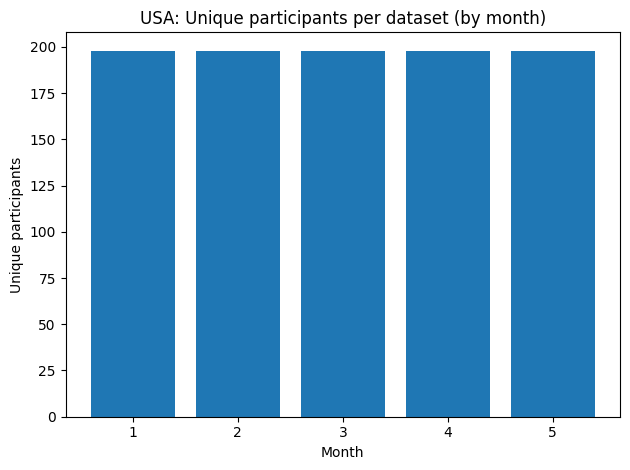

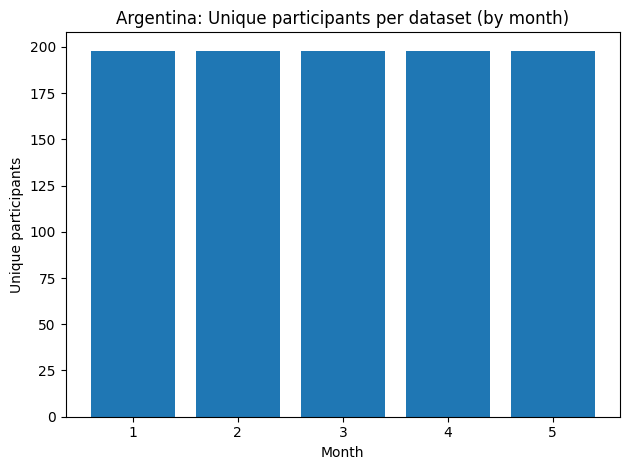

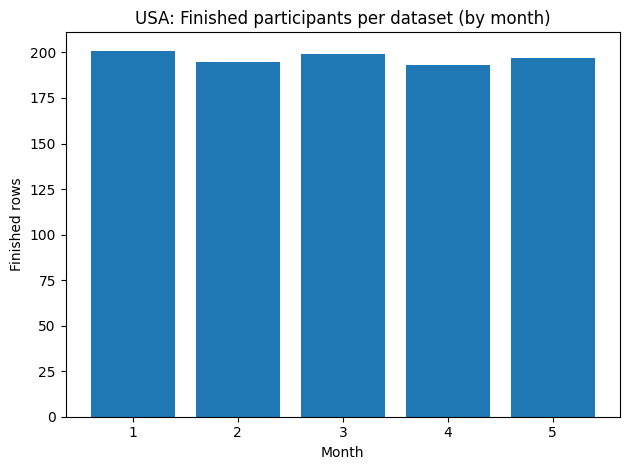

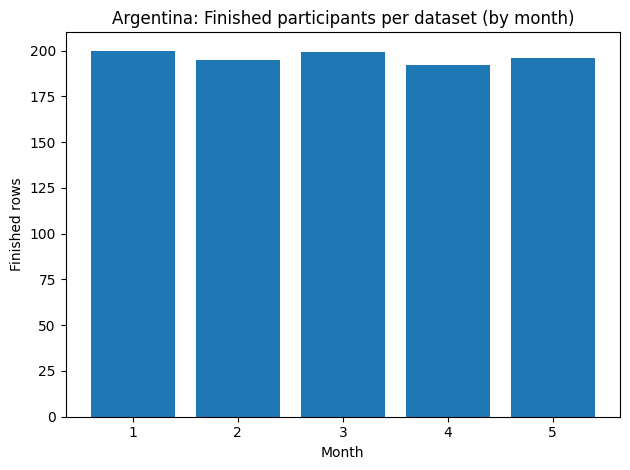

In [22]:
import os
import re
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt


def extract_month(path):
    m = re.search(r"month(\d+)\.csv$", os.path.basename(path))
    return int(m.group(1)) if m else None


def summarize_files(file_list, country_label):
    out = []
    for fp in file_list:
        try:
            df = pd.read_csv(fp, usecols=["ParticipantID"])
        except Exception:
            try:
                df = pd.read_csv(fp)
            except Exception:
                continue
        month = extract_month(fp)
        uniq = (
            df["ParticipantID"].nunique(dropna=True)
            if "ParticipantID" in df.columns
            else len(df)
        )
        total_rows = len(df)
        out.append(
            {
                "country": country_label,
                "month": month,
                "unique_participants": uniq,
                "total_rows": total_rows,
                "file": fp,
            }
        )
    return out


# Collect your files
usa_files = sorted(glob.glob("usa_dream_study_month*.csv"), key=extract_month)
arg_files = sorted(glob.glob("argentina_dream_study_month*.csv"), key=extract_month)

rows = []
rows.extend(summarize_files(usa_files, "USA"))
rows.extend(summarize_files(arg_files, "Argentina"))

summary_df = pd.DataFrame(rows)

# Optional: add finished rows from JSON
finished_map = {}
if os.path.exists("data_quality_report.json"):
    with open("data_quality_report.json", "r") as f:
        report = json.load(f)
    for key, rep in report.items():
        if key in ("attrition_summary",):
            continue
        if isinstance(rep, dict) and "finished_rows" in rep:
            m = re.match(r"(USA|Argentina)_Month(\d+)$", key)
            if m:
                finished_map[(m.group(1), int(m.group(2)))] = rep["finished_rows"]

if not summary_df.empty:
    summary_df["finished_rows"] = summary_df.apply(
        lambda r: finished_map.get((r["country"], int(r["month"])), None), axis=1
    )
    summary_df = summary_df.sort_values(["country", "month"]).reset_index(drop=True)
    print(summary_df)

    # Plot unique participants per month (USA)
    usa_plot = summary_df[summary_df["country"] == "USA"].sort_values("month")
    plt.figure()
    plt.bar(usa_plot["month"].astype(str), usa_plot["unique_participants"])
    plt.title("USA: Unique participants per dataset (by month)")
    plt.xlabel("Month")
    plt.ylabel("Unique participants")
    plt.tight_layout()
    plt.show()

    # Plot unique participants per month (Argentina)
    arg_plot = summary_df[summary_df["country"] == "Argentina"].sort_values("month")
    plt.figure()
    plt.bar(arg_plot["month"].astype(str), arg_plot["unique_participants"])
    plt.title("Argentina: Unique participants per dataset (by month)")
    plt.xlabel("Month")
    plt.ylabel("Unique participants")
    plt.tight_layout()
    plt.show()

    # Plot finished rows if available
    if summary_df["finished_rows"].notna().any():
        usa_fin = usa_plot.dropna(subset=["finished_rows"])
        if not usa_fin.empty:
            plt.figure()
            plt.bar(usa_fin["month"].astype(str), usa_fin["finished_rows"])
            plt.title("USA: Finished participants per dataset (by month)")
            plt.xlabel("Month")
            plt.ylabel("Finished rows")
            plt.tight_layout()
            plt.show()

        arg_fin = arg_plot.dropna(subset=["finished_rows"])
        if not arg_fin.empty:
            plt.figure()
            plt.bar(arg_fin["month"].astype(str), arg_fin["finished_rows"])
            plt.title("Argentina: Finished participants per dataset (by month)")
            plt.xlabel("Month")
            plt.ylabel("Finished rows")
            plt.tight_layout()
            plt.show()
else:
    print("No dataset CSV files found. Please place them in the same folder.")